100%|██████████| 2769/2769 [00:18<00:00, 151.09it/s]



Training Model with Input Shape: (20, 24)


C:\Users\anya2\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,745 (139.63 KB)

 Trainable params: 35,745 (139.63 KB)

 Non-trainable params: 0 (0.00 B)


             🏆 MODEL EVALUATION 🏆

--- 1. General Test Set Metrics (Random Split) ---
R2 Score: 0.9904
MSE: 18.8628
RMSE: 4.3431
MAE: 2.9178


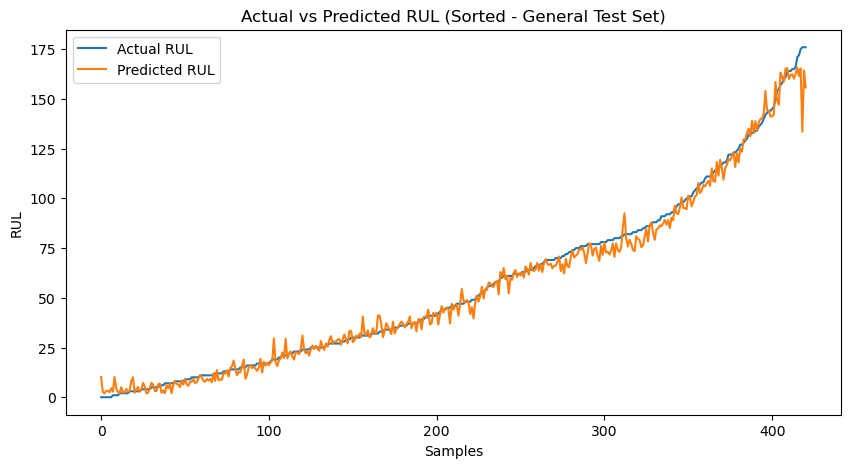


--- 2. Unseen Battery B0005 Metrics ---
R2 Score: 0.9957
MSE: 7.8134
RMSE: 2.7952
MAE: 2.3144


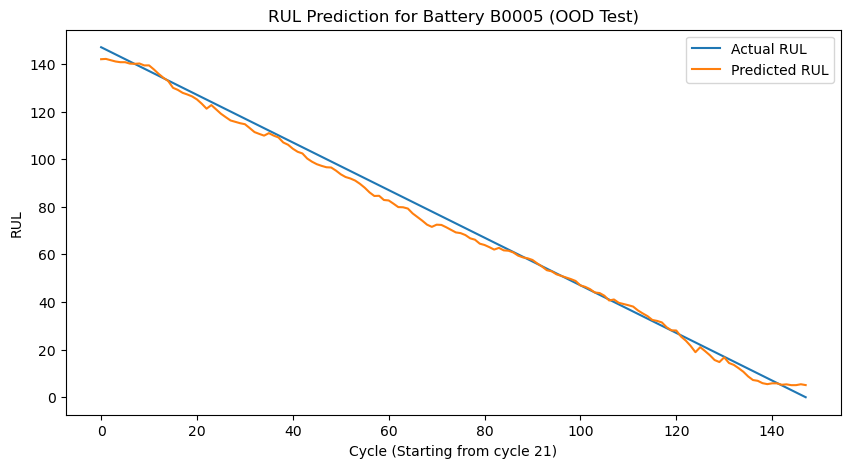

In [1]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- METRICS FUNCTION ---
def calculate_standard_metrics(y_true, y_pred):
    """Calculates MSE, RMSE, MAE, and R-squared (R2) score."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        "R2 Score": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }

# --- 0. PATHS AND INITIAL LOADING (UNCHANGED) ---
CYCLES_DIR = r"C:\Users\anya2\Desktop\VDT_PM\datasets\nasaLi_dataset\data"
METADATA_CSV = r"C:\Users\anya2\Desktop\VDT_PM\datasets\nasaLi_dataset\metadata.csv"

# 1) Load metadata
df = pd.read_csv(METADATA_CSV)

# 2) Convert start_time and clean (UNCHANGED)
def auto_convert_start_time(df, column_name='start_time'):
    col = df[column_name]
    if isinstance(col.iloc[0], (list, np.ndarray)):
        arr = np.vstack(col.values).astype(float)
    elif isinstance(col.iloc[0], str):
        arr = np.array([re.findall(r"[\d\.eE\+\-]+", s) for s in col]).astype(float)
    else:
        raise TypeError("Unsupported format for start_time")
    
    if len(arr) == 0:
        return df

    base_time = pd.to_datetime({
        'year': arr[:, 0].astype(int),
        'month': arr[:, 1].astype(int),
        'day': arr[:, 2].astype(int),
        'hour': arr[:, 3].astype(int),
        'minute': arr[:, 4].astype(int),
        'second': np.floor(arr[:, 5]).astype(int)
    }, errors='coerce')
    fractional = arr[:, 5] - np.floor(arr[:, 5])
    df[column_name] = base_time + pd.to_timedelta(fractional, unit='s')
    return df

df = auto_convert_start_time(df, "start_time")
clean_df = df[df['Capacity'] != "[]"].copy()

# 3) Numeric conversion and discharge filter (UNCHANGED)
for col in ["Capacity", "Re", "Rct"]:
    clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')

df1 = clean_df.sort_values(by=['battery_id', 'type']).reset_index(drop=True)
df_dis = df1[df1['type'].str.lower() == 'discharge'].copy()
columns_to_drop = ["Re", "Rct"]
df_dis = df_dis.drop(columns=columns_to_drop, errors='ignore').reset_index(drop=True)


# --- 4. FEATURE EXTRACTION (UNCHANGED) ---
def extract_discharge_features(df_cyc):
    df_cyc = df_cyc.sort_values("Time").reset_index(drop=True)
    features = {}
    t = df_cyc["Time"].astype(float)
    v = df_cyc["Voltage_measured"].astype(float)
    c = df_cyc["Current_measured"].astype(float)
    temp = df_cyc["Temperature_measured"].astype(float)
    
    # time
    features["cycle_duration"] = t.iloc[-1] - t.iloc[0]
    # voltage
    features["Voltage_mean"] = v.mean()
    features["Voltage_std"] = v.std()
    features["Voltage_min"] = v.min()
    features["Voltage_max"] = v.max()
    features["Voltage_drop"] = v.max() - v.min()
    features["dV_dt_mean"] = np.mean(np.gradient(v, t))
    # current
    features["Current_mean"] = c.mean()
    features["Current_std"] = c.std()
    features["Current_min"] = c.min()
    features["Current_max"] = c.max()
    # LOAD features
    features["Current_load_mean"] = df_cyc["Current_load"].astype(float).mean()
    features["Voltage_load_mean"] = df_cyc["Voltage_load"].astype(float).mean()
    # temperature
    features["Temperature_mean"] = temp.mean()
    features["Temperature_std"] = temp.std()
    features["Temperature_max"] = temp.max()
    features["Temperature_rise_rate"] = np.mean(np.gradient(temp, t))
    return features

# Apply feature extraction
all_features = []
for idx, row in tqdm(df_dis.iterrows(), total=len(df_dis)):
    fpath = os.path.join(CYCLES_DIR, row["filename"])
    if not os.path.exists(fpath):
        continue
        
    try:
        cyc = pd.read_csv(fpath)
        feats = extract_discharge_features(cyc)
    except Exception as e:
        continue
        
    # --- Attach metadata ---
    feats["battery_id"] = row["battery_id"]
    feats["filename"] = row["filename"]
    feats["start_time"] = row["start_time"]
    feats["ambient_temperature"] = row["ambient_temperature"]
    feats["Capacity"] = row["Capacity"]
    all_features.append(feats)

df_feat = pd.DataFrame(all_features)
df_feat = df_feat.sort_values(["battery_id", "start_time"]).reset_index(drop=True)
df = df_feat.copy()


# --- 5. CORRECT RUL AND NEW FEATURE GENERATION (MODIFIED) ---

# 5.1 CORRECT RUL Calculation: RUL is now per-battery.
df['cycle_index'] = df.groupby('battery_id').cumcount() + 1
df['RUL'] = df.groupby('battery_id')['cycle_index'].transform(lambda x: x.max() - x)

# 5.2 Delta_Capacity
df["Delta_Capacity"] = df.groupby('battery_id')["Capacity"].diff().fillna(0)

# 5.3 Normalized_Capacity (recalculated based on initial capacity per battery)
initial_capacity = df.groupby('battery_id')["Capacity"].transform('first')
df["Normalized_Capacity"] = df["Capacity"] / initial_capacity

# 5.4 **CRITICAL FIX: ADD INITIAL STATE FEATURES**
initial_feats = df.loc[df.groupby('battery_id')['cycle_index'].idxmin()]
initial_feats = initial_feats[['battery_id', 'Capacity', 'Voltage_mean', 'Current_mean', 'ambient_temperature']].rename(
    columns={'Capacity': 'Init_Capacity', 
             'Voltage_mean': 'Init_V_Mean', 
             'Current_mean': 'Init_C_Mean',
             'ambient_temperature': 'Init_Amb_Temp'}
)

df = df.drop(columns=['ambient_temperature'], errors='ignore') 
df = df.merge(initial_feats, on='battery_id', how='left')


# --- 6. LSTM DATA PREPARATION (MODIFIED) ---
test_battery = "B0005"
train_df = df[df['battery_id'] != test_battery]
test_df  = df[df['battery_id'] == test_battery]

# 6.1 Select features & target (UPDATED to include initial state features)
feature_cols = [
    'cycle_duration', 'Voltage_mean', 'Voltage_std', 'Voltage_min', 'Voltage_max',
    'Voltage_drop', 'dV_dt_mean', 'Current_mean', 'Current_std', 'Current_min',
    'Current_max', 'Current_load_mean', 'Voltage_load_mean', 'Temperature_mean',
    'Temperature_std', 'Temperature_max', 'Temperature_rise_rate',
    'Capacity', 'Delta_Capacity', 'Normalized_Capacity', 
    'Init_Capacity', 'Init_V_Mean', 'Init_C_Mean', 'Init_Amb_Temp'  # <--- NEW FEATURES
]
target_col = "RUL"
SEQ_LEN = 20

# 6.2 Scale Features (using only training data stats)
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

df_scaled = df.copy()
df_scaled[feature_cols] = scaler.transform(df[feature_cols])


# 6.3 Sliding Window Function (UNCHANGED)
def create_sliding_windows(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data.iloc[i:i+seq_len][feature_cols].values)
        y.append(data.iloc[i + seq_len][target_col])
    return np.array(X), np.array(y)

# 6.4 Build sequences per battery
X_list, y_list = [], []
for bid in df_scaled["battery_id"].unique():
    temp = df_scaled[df_scaled["battery_id"] == bid].sort_values("cycle_index")
    X_u, y_u = create_sliding_windows(temp, SEQ_LEN)
    
    if X_u.shape[0] == 0:
        continue
    
    X_list.append(X_u)
    y_list.append(y_u)

X = np.vstack(X_list)
y = np.concatenate(y_list)

# 6.5 Train/Test Split (on the sequence data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# --- 7. BUILD AND TRAIN LSTM MODEL (UNCHANGED) ---
print(f"\nTraining Model with Input Shape: ({SEQ_LEN}, {len(feature_cols)})")

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, len(feature_cols))),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=0
)

# --- 8. EVALUATE AND PLOT (MODIFIED FOR METRICS) ---
print("\n" + "="*50)
print("             🏆 MODEL EVALUATION 🏆")
print("="*50)

# --- 8.1 General Test Set Evaluation ---
y_pred = model.predict(X_test, verbose=0)
general_metrics = calculate_standard_metrics(y_test, y_pred.flatten())

print("\n--- 1. General Test Set Metrics (Random Split) ---")
for name, value in general_metrics.items():
    print(f"{name}: {value:.4f}")

# Plot General Test Set RUL
sorted_idx = np.argsort(y_test)
y_test_sorted = y_test[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]

plt.figure(figsize=(10,5))
plt.plot(y_test_sorted, label='Actual RUL')
plt.plot(y_pred_sorted, label='Predicted RUL')
plt.title("Actual vs Predicted RUL (Sorted - General Test Set)")
plt.xlabel("Samples")
plt.ylabel("RUL")
plt.legend()
plt.show()


# --- 8.2 B0005 Specific Prediction and Evaluation ---
battery = "B0005"
temp = df_scaled[df_scaled["battery_id"] == battery].sort_values("cycle_index")
X_b, y_b = create_sliding_windows(temp, SEQ_LEN)

if X_b.shape[0] > 0:
    y_pred_b = model.predict(X_b, verbose=0)

    # Actual RUL (unscaled) for B0005 starting after sequence length
    temp_original = df[df["battery_id"] == battery].sort_values("cycle_index").iloc[SEQ_LEN:]
    y_b_original = temp_original[target_col].values
    
    y_pred_b_flat = y_pred_b.flatten()

    # Calculate metrics for the critical B0005 battery
    b0005_metrics = calculate_standard_metrics(y_b_original, y_pred_b_flat)
    
    print(f"\n--- 2. Unseen Battery {battery} Metrics ---")
    for name, value in b0005_metrics.items():
        print(f"{name}: {value:.4f}")

    # Plot B0005 RUL
    if len(y_b_original) == len(y_pred_b_flat):
        plt.figure(figsize=(10,5))
        plt.plot(y_b_original, label="Actual RUL")
        plt.plot(y_pred_b_flat, label="Predicted RUL")
        plt.title(f"RUL Prediction for Battery {battery} (OOD Test)")
        plt.xlabel(f"Cycle (Starting from cycle {SEQ_LEN + 1})")
        plt.ylabel("RUL")
        plt.legend()
        plt.show()
    else:
        print(f"Skipping B0005 plot: Length mismatch ({len(y_b_original)} vs {len(y_pred_b_flat)})")
else:
    print(f"Skipping B0005 prediction: Insufficient cycles ({len(temp)})")

In [3]:
import joblib
from tensorflow.keras.models import load_model

# Assuming 'model' (trained LSTM) and 'scaler' (fitted StandardScaler)
# are the objects from your previous code execution.

# --- Saving the Model and Scaler ---
MODEL_PATH = 'rul_lstm_model.keras'  # Keras recommended format
SCALER_PATH = 'feature_scaler.joblib'

# 1. Save the Keras LSTM Model
model.save(MODEL_PATH)
print(f"✅ Trained LSTM Model saved successfully to: {MODEL_PATH}")

# 2. Save the fitted StandardScaler
joblib.dump(scaler, SCALER_PATH)
print(f"✅ Fitted StandardScaler saved successfully to: {SCALER_PATH}")

# # -------------------------------------------------------------------
# # --- Example: How to Load Them for Future Prediction ---

# # 1. Load the Model
# loaded_model = load_model(MODEL_PATH)
# print("\nModel loaded successfully for prediction.")

# # 2. Load the Scaler
# loaded_scaler = joblib.load(SCALER_PATH)
# print("Scaler loaded successfully for preprocessing.")

# # Now, 'loaded_model' and 'loaded_scaler' can be used in your deployment environment
# # to process new battery data (like B0006) and generate RUL predictions.

✅ Trained LSTM Model saved successfully to: rul_lstm_model.keras
✅ Fitted StandardScaler saved successfully to: feature_scaler.joblib
